# Time Construction Distribution

In part 1 of time construction analysis, I used exploratory analysis to find the top major forms amongst time constructions in Biblical Hebrew. That analysis culminated in a tokenization strategy which labeled like-elements within time constructions to obtain raw groups. Those groups were counted, and it was found that out of 312 raw different surface forms, the top 11 attested for 75% of individual instances. These few forms thus encapsulate a majority of the data.

In this notebook, I want to break down the major subcategories of the top surface forms. For instance, the most common token is `prep.time`, i.e. a preposition + a time word. But there are major differences amongst this group. Specifically, the time noun is often specified by a further element. In some cases this further element consists of an infinitival clause that modifies the time noun. Some time nouns are statistically associated with the time function, such as יום, שׁנה etc. But some are not, such as nouns which describe events. These are of a different semantic type.

This analysis will follow a similar strategy as part 1, using a process of elimination to narrow down the primary groups amongst the data. 

In [1]:
from setup_tools import * # get all of the tools for the analyses

This is Text-Fabric 7.8.5
Api reference : https://annotation.github.io/text-fabric/Api/Fabric/

123 features found and 5 ignored
  0.00s loading features ...
   |     0.00s No structure info in otext, the structure part of the T-API cannot be used
  7.59s All features loaded/computed - for details use loadLog()


# Helper Data

In [3]:
# label2result = collections.defaultdict(list)
# for cx in F.otype.s('chunk'):
#     label2result[F.label.v(cx)].append(L.d(cx, 'phrase'))

# Time Constructions: Their Distribution and Make-Up

This analysis repeats some parts of previous studies, [SBH_time_expressions](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/SBH_time_expressions.ipynb) and [duratives](https://nbviewer.jupyter.org/github/CambridgeSemiticsLab/BH_time_collocations/blob/master/analysis/duratives.ipynb), but now with the new time construction data and for all known time constructions in the Hebrew Bible.

### Basic BSHA Stats

#### number of phrases in BHSA

In [4]:
phrases = A.search('''

phrase
/with/
    word language=Hebrew
/-/

''')

XXXX (True, frozenset({'Hebrew'}))
  1.70s 249383 results


#### number of functions in BHSA

In [5]:
len(F.function.freqList())

29

In [6]:
F.function.freqList()

(('Pred', 57070),
 ('Conj', 46153),
 ('Subj', 31952),
 ('Cmpl', 30036),
 ('Objc', 22667),
 ('PreC', 19395),
 ('Adju', 9514),
 ('Rela', 6328),
 ('Nega', 6044),
 ('PreO', 5402),
 ('Time', 4072),
 ('Modi', 3738),
 ('Loca', 2625),
 ('Intj', 1621),
 ('Voct', 1607),
 ('Ques', 1200),
 ('Frnt', 1137),
 ('PreS', 887),
 ('NCop', 597),
 ('IntS', 251),
 ('PrAd', 246),
 ('Supp', 178),
 ('PtcO', 164),
 ('Exst', 143),
 ('NCoS', 101),
 ('ModS', 35),
 ('EPPr', 22),
 ('ExsS', 14),
 ('PrcS', 8))

Hebrew time phrases (not processed and raw).

In [7]:
tp = A.search('''

phrase function=Time
/with/
    word language=Hebrew
/-/
    
''')

XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'Time'}))
XXXX (True, frozenset({'Hebrew'}))
  1.11s 3953 results


After the post-processing...

In [8]:
time_cx = A.search('''

chunk label=timephrase
    
''')

XXXX (True, frozenset({'timephrase'}))
  0.09s 3881 results


## Time Construction Distribution and Selectivity

### Distribution of Time Constructions Across Corpus

In [9]:
strip_data = []
covered_chapters = set()
bookboundaries = {}

twelve = ('Hosea', 'Joel', 'Amos', 'Obadiah',
          'Jonah', 'Micah', 'Nahum', 'Habakkuk',
          'Zephaniah', 'Haggai', 'Zechariah',
          'Malachi')

# map grouped book names
megilloth = ('Ruth', 'Lamentations', 'Ecclesiastes', 'Esther', 'Song_of_songs')
book_map = {'1_Kings': 'Kings', '2_Kings':'Kings', '1_Samuel':'Samuel',
            '2_Samuel':'Samuel', '1_Chronicles':'Chronicles', '2_Chronicles':'Chronicles',}
for book in twelve: book_map[book] = 'Twelve'
for book in megilloth: book_map[book] = 'Megilloth'
for book in ('Ezra', 'Nehemiah', 'Daniel'): book_map[book] = 'Daniel-Neh'

    
# iterate through constructions and gather book data
this_book = None

for cx in F.label.s('timephrase'):
    chapter_node = L.u(cx, 'chapter')[0]
    book, chapter, verse = T.sectionFromNode(cx)
    this_book = book_map.get(book, book)
    covered_chapters.add(chapter_node)
    chapter_label = len(covered_chapters)
    
    if this_book not in bookboundaries: # add first chapter to boundaries for plotting
        bookboundaries[this_book] = chapter_label
    
    strip_data.append(chapter_label)

Distribution of Time Function Constructions by Chapter (smaller books are grouped together)


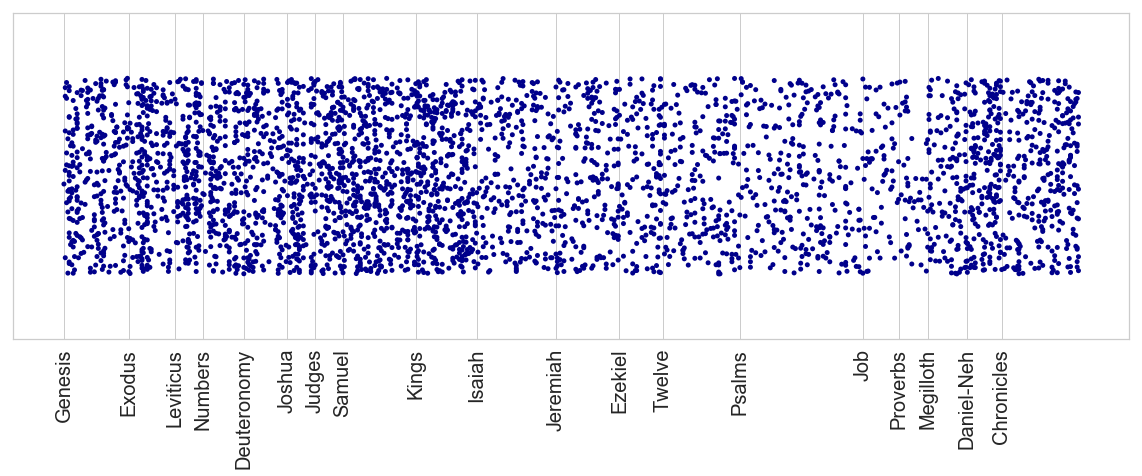

In [11]:
strip_title = 'Distribution of Time Function Constructions by Chapter (smaller books are grouped together)'
plt.figure(figsize=(20, 6))
sns.stripplot(x=strip_data, jitter=0.3, color='darkblue')
plt.xticks(ticks=list(bookboundaries.values()), labels=list(bookboundaries.keys()), rotation='vertical', size=20)
plt.savefig(f'{firstyear}/chapter_distribution.png', dpi=300, bbox_inches='tight')
print(strip_title) # keep title out of savefig
plt.show()

### Degree of Dispersion Compared to Other Functions

The strip chart gives a good sense of how spread out time constructions are in the Hebrew Bible. We can also see that the distribution is sparser throughout the poetics books, from Isaiah until the beginning of Daniel-Nehemiah. This variation in density can be quantified using a statistical measure known as **degree of dispersion** (Gries, S. 2008. "Dispersions and Adjusted Frequencies in Corpora"). We can use this measure to compare the time construction against other functions in corpus.

In [14]:
# count all phrase tokens per book
phrase_functions = collections.defaultdict(lambda:collections.Counter())

functionmap = {'PreO': 'Pred', 'PreS': 'Pred', 'PtcO': 'Pred', # collect some of the idiosyncratic BHSA functions
              'IntS': 'Intj', 'NCoS': 'NCop','ModS': 'Modi',
              'ExsS': 'Exst'}

for phrase in F.otype.s('phrase'):
    book, chapter, verse = T.sectionFromNode(phrase)
    book = book_map.get(book, book)
    # use constructional phrases only for Time function phrases
    # some time phrases are excluded, others follow a primary time phrase
    # ignore excluded TPs and secondary TPs
    if F.function.v(phrase) == 'Time':
        time_cx = L.u(phrase, 'chunk')[0] if L.u(phrase, 'chunk') else tuple()
        time_cx = time_cx if F.label.v(time_cx) == 'timephrase' else tuple()
        if not time_cx: # excluded TP
            continue
        elif list(L.d(time_cx, 'phrase')).index(phrase) == 0:
            phrase_functions[book]['Time'] += 1

    # count all other function types
    else:
        funct = functionmap.get(F.function.v(phrase), F.function.v(phrase))
        function = funct2function[funct].title()
        phrase_functions[book][function] += 1
    
    
phrase_functions = pd.DataFrame(phrase_functions).fillna(0)

The BHSA has some idiosyncatic functions that only occur a handfull of times relative to the whole corpus. See especially those below that fall below a frequency of 300:

In [15]:
phrase_functions.sum(1)

Adjunct                                      9514.0
Complement                                  30036.0
Conjunction                                 46153.0
Enclitic Personal Pronoun                      22.0
Existence                                     157.0
Fronted Element                              1137.0
Interjection                                 1872.0
Location                                     2625.0
Modifier                                     3773.0
Negation                                     6044.0
Negative Copula                               698.0
Object                                      22667.0
Predicate                                   63523.0
Predicate Complement                        19395.0
Predicate Complement With Subject Suffix        8.0
Predicative Adjunct                           246.0
Question                                     1200.0
Relative                                     6328.0
Subject                                     31952.0
Supplementar

I've decided to remove these marginal forms from the analysis by selecting only those that occur total > 300 times. The new functions are seen below.

In [16]:
phrase_functions = phrase_functions[phrase_functions.sum(1) > 200]

phrase_functions.sum(1).sort_values(ascending=False)

Predicate               63523.0
Conjunction             46153.0
Subject                 31952.0
Complement              30036.0
Object                  22667.0
Predicate Complement    19395.0
Adjunct                  9514.0
Relative                 6328.0
Negation                 6044.0
Modifier                 3773.0
Time                     3521.0
Location                 2625.0
Interjection             1872.0
Vocative                 1607.0
Question                 1200.0
Fronted Element          1137.0
Negative Copula           698.0
Predicative Adjunct       246.0
dtype: float64

In [17]:
expected_prop = phrase_functions.sum() / phrase_functions.sum().sum()
observed_prop = phrase_functions.div(phrase_functions.sum(1), axis=0)
prop_diffs = abs(expected_prop-observed_prop)
dp = prop_diffs.sum(1) / 2
dp = 1-pd.DataFrame(dp, columns=['Degree of Dispersion']).sort_values(by='Degree of Dispersion') # DP score finalized here, NB 1- to make it more intuitive (Bigger==more distributed)

In [18]:
expected_prop.head()

Genesis        0.070847
Exodus         0.052265
Leviticus      0.037976
Numbers        0.046712
Deuteronomy    0.045582
dtype: float64

In [19]:
dp

,Degree of Dispersion
Predicate,0.969039
Subject,0.955506
Conjunction,0.943949
Complement,0.943087
Object,0.940406
Time,0.920999
Predicate Complement,0.910411
Location,0.873687
Modifier,0.865144
Negation,0.852551


In [20]:
dp.loc['Time'] - dp.loc['Adjunct']

Degree of Dispersion    0.071974
dtype: float64

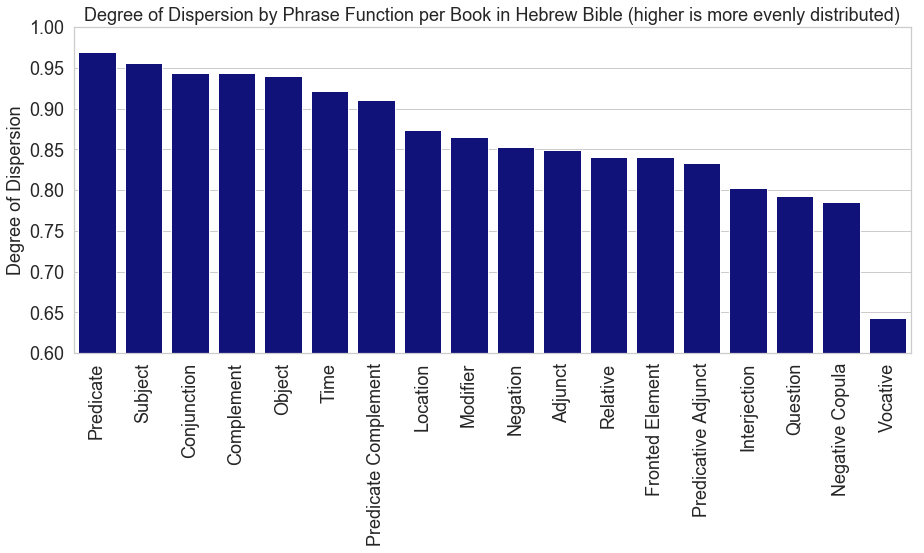

In [22]:
title = 'Degree of Dispersion by Phrase Function per Book in Hebrew Bible (higher is more evenly distributed)'
save = f'{firstyear}phrase_DP.png'
countBarplot(dp, title=title, column='Degree of Dispersion', size=(15, 6), xlab_rotation='vertical', ylim=(1, 0.60), save=save)

It is significant here that the time construction is more consistently spread than the regular Adjunct function. Its spread relative to Location is harder to evaluate due to the presence of some Location functioning phrases residing in the Complement function. The BHSA labels many locative phrases as simple complements to movement verbs without providing a further distinction that they are likewise locative in nature. That is a shortcoming to the data. This data does tell us, however, that the Time function is more evenly spread than the generic adjunct function, and certainly it is more evenly distributed than Vocative or Question phrases.

We observed in the stripplot that the Time function appeared to be less attested in the books ranging from Isaiah through the end of the Megilloth. 

**Presented below is the difference in proportion, per book, between the expected proportion and the actual observed proportion of Time phrases**. They are sorted from greatest to least, with a higher value indicating that the Time function is under-represented in relation to the size of the book.

In [23]:
prop_diffs_book = pd.DataFrame((observed_prop-expected_prop).loc['Time'].sort_values(ascending=False))
prop_diffs_book.columns = ['difference']

prop_diffs_book

,difference
Samuel,0.025233
Joshua,0.014498
Psalms,0.007662
Deuteronomy,0.005540
Kings,0.005424
Twelve,0.004671
Exodus,0.003969
Daniel-Neh,0.003541
Isaiah,0.003271
Judges,0.003235


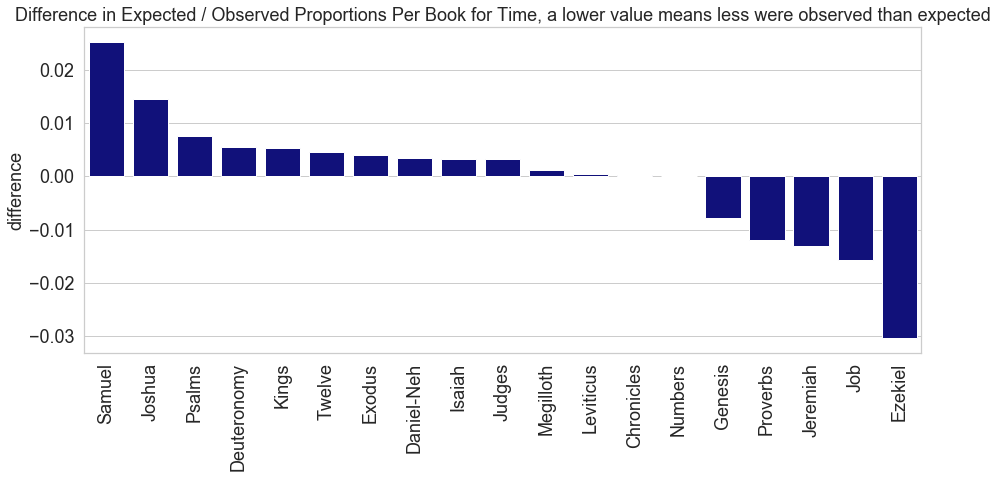

In [24]:
title = 'Difference in Expected / Observed Proportions Per Book for Time, a lower value means less were observed than expected'
countBarplot(prop_diffs_book, column='difference', title=title, size=(15, 6), xlab_rotation='vertical', save=f'{firstyear}dp_book_diff.png')

As expected from observing the strippchart, poetic books like Ezekiel, Job, Jeremiah, Proverbs, and Isaiah contain less than expected frequencies of Time function. The inclusion of Genesis in this group is surprising, although the barplot helps to see that the difference from Isaiah to Ezekiel is proportionately large. Likewise surprising is the difference in spread between Kings and Chronicles.

I am a bit curious how these differences compare with other kinds of functions. Let's look at the `Pred` function, the function that is said to be the most distributed.

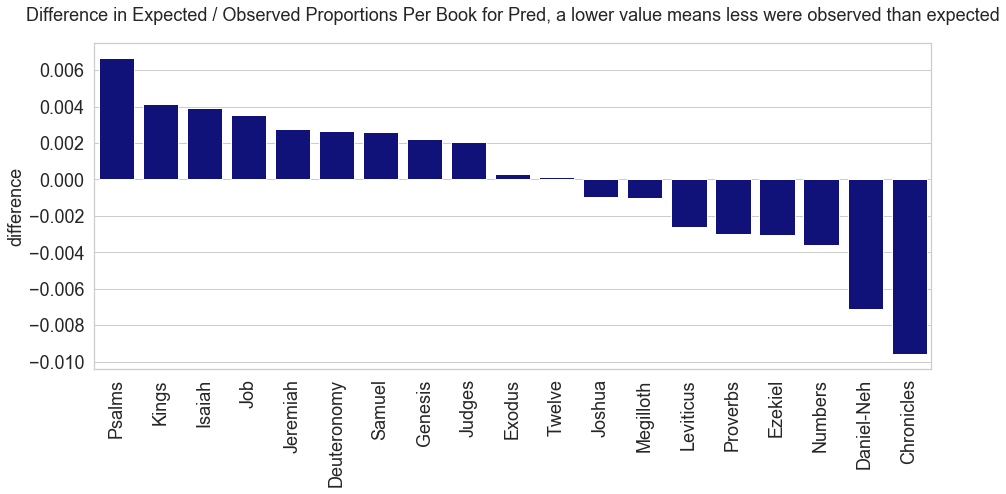

In [25]:
prop_diffs_book_PRED = pd.DataFrame((observed_prop-expected_prop).loc['Predicate'].sort_values(ascending=False))
prop_diffs_book_PRED.columns = ['difference']
title = 'Difference in Expected / Observed Proportions Per Book for Pred, a lower value means less were observed than expected'
countBarplot(prop_diffs_book_PRED, column='difference', title=title, size=(15, 6), xlab_rotation='vertical')

It is very interesting that Chronicles and Daniel-Nehemiah are less verbal than expected, while Psalms is more so! To put it another way, relative to all other books in the corpus, Chronicles and Daniel-Nehemiah have a lower distribution of predicate phrases relative to the total number of phrases they contain.

### Excursus: Why is Pred so underpresented in Chronicles?

To answer this question, let's find the function which is most OVER-represented in the book...

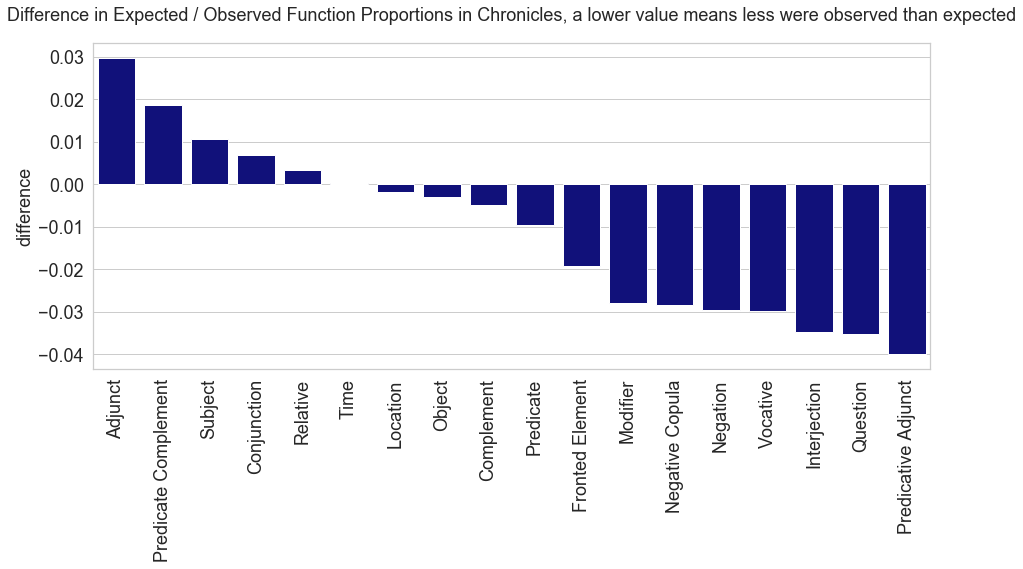

In [26]:
title = 'Difference in Expected / Observed Function Proportions in Chronicles, a lower value means less were observed than expected'
diff_all = observed_prop - expected_prop
chronicles_diffs = pd.DataFrame(diff_all['Chronicles'].sort_values(ascending=False))
chronicles_diffs.columns = ['difference']
countBarplot(chronicles_diffs, title=title, column='difference', size=(15, 6), xlab_rotation='vertical')

The PreC seems like a possible candidate explanation...To find out for sure we could do a count of nominal clauses between all books, and see if Chronicles has a higher than expected proportion. But for now we will be satisfied with this.

### Examine Variety within the Head Lexemes of Phrases with Various Functions

I want to know how the Time phrase compares with other phrase functions in terms of the diversity of its head lexemes. In other words, does the Time function have a wide variety of terms that it regularly uses, or is it more highly selective of key terms? If the latter is true, it could show that time nouns are specialized in their use. Note that for this test, I do not look at lexical heads, but semantic heads. So, for instance, for a prepositional phrase I do not take the preposition but rather the object of the preposition. 

After making a count of all head lexeme/function co-ocurrences, I will normalize the number of lexemes per 100 uses of each function. The normalization is adapted from the helpful explanation of the [grammar lab](http://www.thegrammarlab.com/?p=160). I've adapted it by replacing "word counts" with "lexeme counts" and "corpus size" with "frequency of function." The frequency of all functions is calculated by simply taking the sum of the co-occurrence function counts.

In [27]:
# make a co-occurrence matrix of function columns and co-occurring head lexeme rows

function_heads = collections.defaultdict(lambda: collections.Counter())

for ph in F.otype.s('phrase'):
    
    if not E.head.t(ph): # it should have a head
        continue
    
    funct = functionmap.get(F.function.v(ph), F.function.v(ph))
    function = funct2function[funct].title()
    
    if function in {'Exst', 'EPPr'}:
        continue
    
    for head in E.nhead.t(ph):
        function_heads[function][F.lex.v(head)] += 1
        
function_heads = pd.DataFrame(function_heads).fillna(0)

Make the normalizations...

In [28]:
function_to_lexs = dict((funct, (function_heads[function_heads[funct] > 0]).shape[0]) for funct in function_heads)
function_to_lexs = pd.DataFrame.from_dict(function_to_lexs, orient='index')
function_to_lexs = function_to_lexs[(function_to_lexs > 4).all(1)]

In [29]:
norm_fs_lex = function_to_lexs*100
norm_fs_lex = norm_fs_lex.div(function_heads.sum(), axis='rows')
norm_fs_lex = norm_fs_lex.sort_values(by=0).dropna()

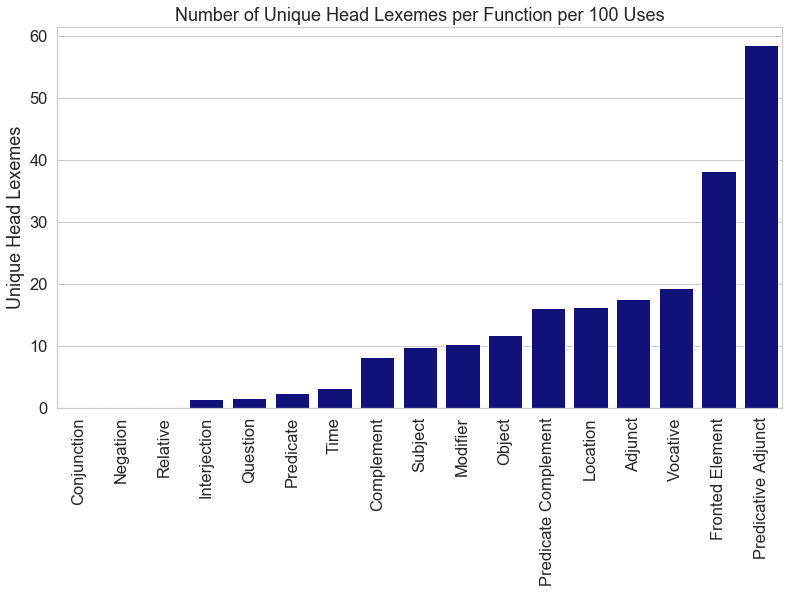

,0
Conjunction,0.080168
Negation,0.132363
Relative,0.142225
Interjection,1.433882
Question,1.583333
Predicate,2.307826
Time,3.253544
Complement,8.129621
Subject,9.820010
Modifier,10.343035


In [31]:
plt.figure(figsize=(13, 7))
sns.barplot(data=norm_fs_lex.transpose(), color='darkblue')
plt.xticks(rotation='vertical')
plt.ylabel('Unique Head Lexemes')
#plt.xlabel('Phrase Functions')
plt.savefig(f'{firstyear}unique_heads.png', dpi=300, bbox_inches='tight')
#plt.annotate('Time is very selective', xy=(10, 3), xytext=(10, 10), arrowprops=dict(facecolor='red', shrink=0.05), size=18)
plt.title('Number of Unique Head Lexemes per Function per 100 Uses')
plt.show()
display(norm_fs_lex)